In [1]:
from pypion.ReadData import ReadData
from pypion.argparse_command import InputValues
import yt

import numpy as np
import math
from astropy import units as u

import os
import glob
import re

In [2]:
path = "/mnt/massive-stars/data/thomas_simulations/wr140-sims/covertex_start/orig_res/wr140-hydro-cool-n064/"
# path = "/mnt/local/thomas/test_data/wr140-mhd-n256"

fluid_quantity = "Density"
tolerance = [-22, -27]
plane = "XY"


data_path = path
if os.path.exists(path):
    print(f"Chosen datapath: {path}")
else:
    print(f"Directory does not exist: {path}")
    exit()
    
########### Base name of SILO files ############################
filename=sorted(os.listdir(data_path))[2].replace('_level00_0000.00000000.silo','')
print(filename)

########### Define desired fluid quantity ######################
Quantity = fluid_quantity
print(f"Fluid quantity: {Quantity}")
Tolerance = tolerance
print(f"vmin: {Tolerance[0]} \nvmax: {Tolerance[1]}")

########### If 3D, specify the coordinate plane ################
surface_options = ['XY', 'XZ', 'YZ']
Surface = plane
if surface_options.count(Surface) > 0:
    print(f"Chosen surface: {Surface}")
else:
    print(f"Invalid Surface Choice: {Surface}")
    exit()


def make_snapshots(data_path, filename):
    ########## Cataloging silo files ###############################
    os.chdir(data_path)
    file_list = glob.glob('*.silo', recursive=True)
    level_list = []
    files = []

    for file in file_list:
        level = re.search('_level(.*)_', file)
        if level == None:
            pass
        else:
            level = level.group(1)
            if not level in level_list:
                level_list.append(level)
    level_list.sort()

    ########## Categorizing data files into levels #################
    if len(level_list) == 1: 
        print('Simulation Info: Single level')
        catalog = []
        files = sorted(glob.glob(filename + '_0000.*.silo'))
        catalog.append(files)
    else:
        print(f'Simulation Info: {len(level_list)} levels')
        catalog = []
        for i in range(len(level_list)):
            files = sorted(glob.glob(f"{filename}_level{level_list[i]}_0000.*.silo"))
            catalog.append(files)
            
    # Bundle silo files of different levels of same time instant into a snapshot.
    evolution = np.array(catalog).T
    print(f"Shape of evolution array: {evolution.shape}")
    return evolution

########### Make snapshots of the simulation ###################
evolution = make_snapshots(data_path, filename)

Chosen datapath: /mnt/massive-stars/data/thomas_simulations/wr140-sims/covertex_start/orig_res/wr140-hydro-cool-n064/
WR140_hydro_cool_d3l6n064
Fluid quantity: Density
vmin: -22 
vmax: -27
Chosen surface: XY
Simulation Info: 6 levels
Shape of evolution array: (423, 6)


In [3]:
data = ReadData(evolution[0])
N_level = data.nlevels()
N_grids = data.ngrid()
sim_time = data.sim_time()
domain_size = data.dom_size()

baseline_data = data.get_3Darray(Quantity)
fluid_parameter = baseline_data['data']

print(N_grids, N_level, domain_size, sim_time)

dims = N_grids 

# dims = [64, 256, 256]

[64, 64, 64] 6 {'DomSize': [16, 32, 32], 'Ndom': [4, 2, 2]} 0.0 s


In [4]:
ds_list = []

for i in range(90,91):
    data = ReadData(evolution[i])
    sim_time = data.sim_time()
    arr = np.array(evolution[i])

    data_den = ReadData(arr).get_3Darray("Density")['data']
    data_temp = ReadData(arr).get_3Darray("Temperature")['data']
    data_velx = ReadData(arr).get_3Darray("VelocityX")['data']
    data_vely = ReadData(arr).get_3Darray("VelocityY")['data']
    data_velz = ReadData(arr).get_3Darray("VelocityZ")['data']
    data_ngmask = ReadData(arr).get_3Darray("NG_Mask")['data']

    grid_data = [dict(left_edge=[0.5-0.5**(n+1)]*len(dims), right_edge=[0.5+0.5**(n+1)]*len(dims), level=n, dimensions=dims) for n in range(N_level)]

    i = 0
    for g in grid_data:
        g[("gas", "density")] = (data_den[i], "g/cm**3")
        g[("gas", "temperature")] = (data_temp[i], "K")
        g[("gas", "velocity_x")] = (data_velx[i], "cm/s")
        g[("gas", "velocity_y")] = (data_vely[i], "cm/s")
        g[("gas", "velocity_z")] = (data_velz[i], "cm/s")
        g[("gas", "NG_Mask")] = (data_ngmask[i], "cm/s")
        i += 1


    ds = yt.load_amr_grids(grid_data, dims, length_unit="1e15 * cm", geometry=("cartesian", ("z","y","x")),sim_time=sim_time)
    ds_list.append(ds)  

ts = yt.DatasetSeries(ds_list)

yt : [INFO     ] 2022-10-27 17:35:02,448 Parameters: current_time              = 21565509.521154407 s
yt : [INFO     ] 2022-10-27 17:35:02,450 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2022-10-27 17:35:02,452 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-10-27 17:35:02,453 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-10-27 17:35:02,455 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2022-10-27 17:35:06,895 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-10-27 17:35:06,896 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-10-27 17:35:06,898 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-10-27 17:35:06,899 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-10-27 17:35:06,905 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



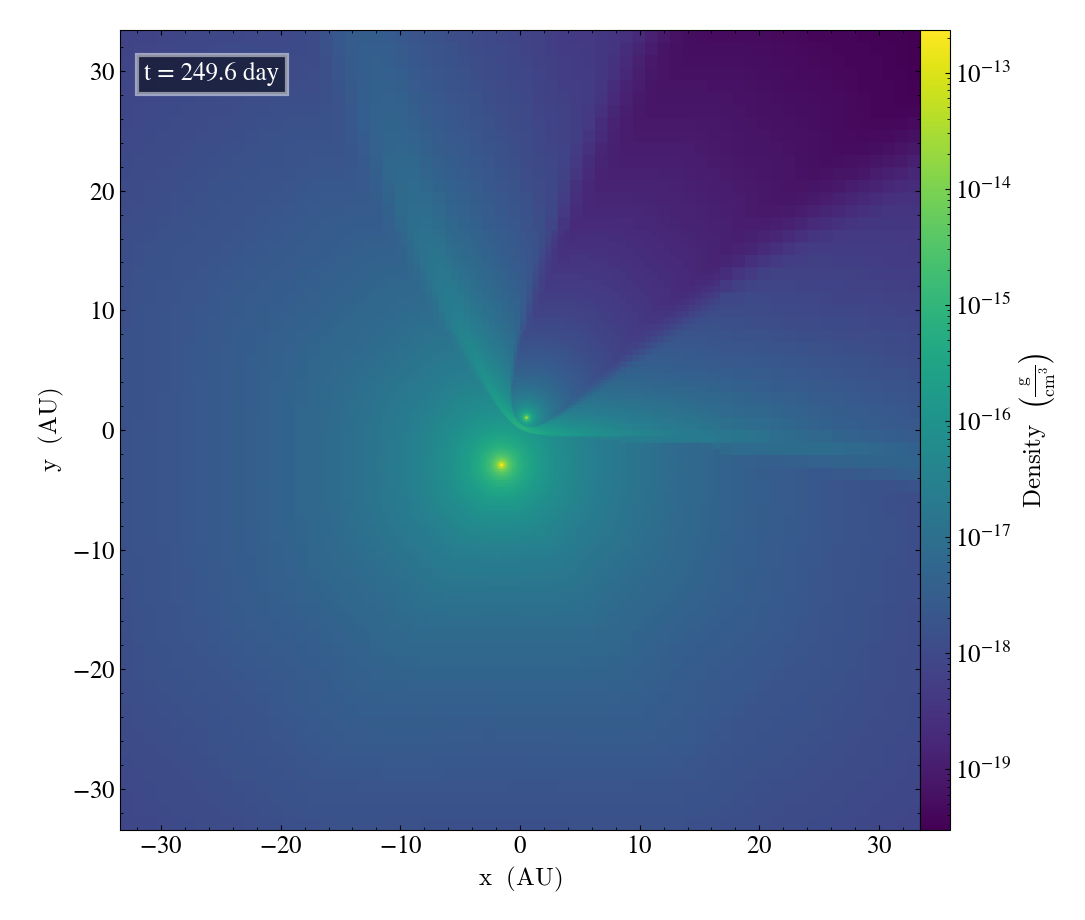

In [5]:
slc = yt.SlicePlot(ts[0], "z", "density", center=('c'),)
slc.set_cmap("density", "viridis")

# slc.zoom(4)
# slc.set_width((1.0, 'cm'))
# slc.annotate_velocity(normalize=True)
# slc.annotate_streamlines("velocity_x", "velocity_y", factor=10, density=2, color="white")
# slc.annotate_contour("temperature", levels=10, clim=(1e6, 1e8), plot_args={"colors":"white"})
# slc.annotate_cell_edges(line_width=0.0005, alpha=0.5)

slc.annotate_timestamp(corner="upper_left", redshift=False, draw_inset_box=True)
# slc.annotate_line_integral_convolution(("gas", "velocity_x"), ("gas", "velocity_y"), lim=(0.5, 0.75))
slc.show()

yt : [INFO     ] 2022-10-27 17:35:11,443 xlim = -1.000000 1.000000
yt : [INFO     ] 2022-10-27 17:35:11,445 ylim = -1.000000 1.000000
yt : [INFO     ] 2022-10-27 17:35:11,446 zlim = -0.500000 0.500000
yt : [INFO     ] 2022-10-27 17:35:11,448 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



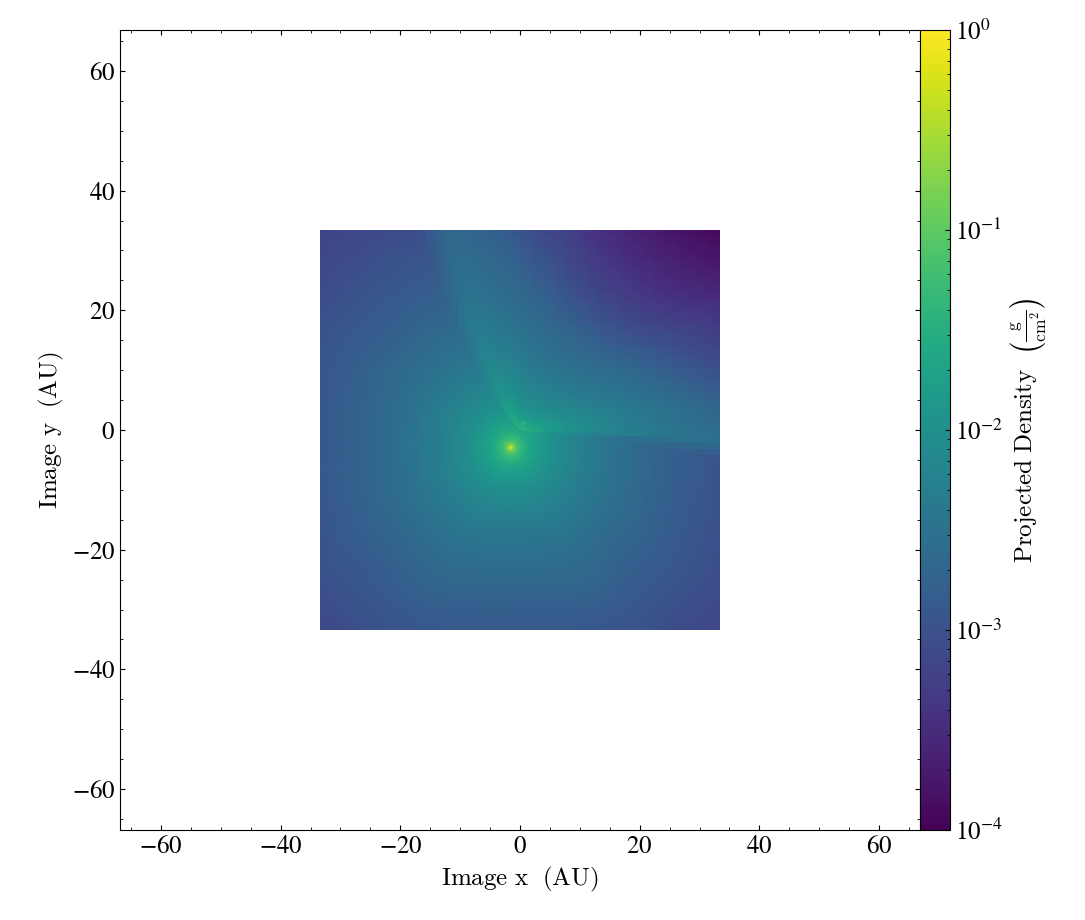

In [6]:
prj = yt.OffAxisProjectionPlot(ts[0], 
                                center=[0.5, 0.5, 0.5], 
                                fields="density", width=[2,2,2], 
                                method="integrate", normal=[-1,0,0] ,
                                north_vector=[0,1,0],
                                # weight_field="temperature"
                                # buff_size=(100,100)
                                )

prj.set_cmap("density", "viridis")
prj.set_zlim("density", 1e-4, 1)
prj.show()

yt : [WARNING  ] 2022-10-27 17:35:30,221 No previously rendered image found, rendering now.
yt : [INFO     ] 2022-10-27 17:35:30,223 Rendering scene (Can take a while).
yt : [INFO     ] 2022-10-27 17:35:30,233 Creating volume
yt : [INFO     ] 2022-10-27 17:35:30,474 Creating transfer function
yt : [INFO     ] 2022-10-27 17:35:30,476 Calculating data bounds. This may take a while. Set the TransferFunctionHelper.bounds to avoid this.
yt : [INFO     ] 2022-10-27 17:35:31,875 Saving rendered image to /mnt/local/thomas/frame0000.png


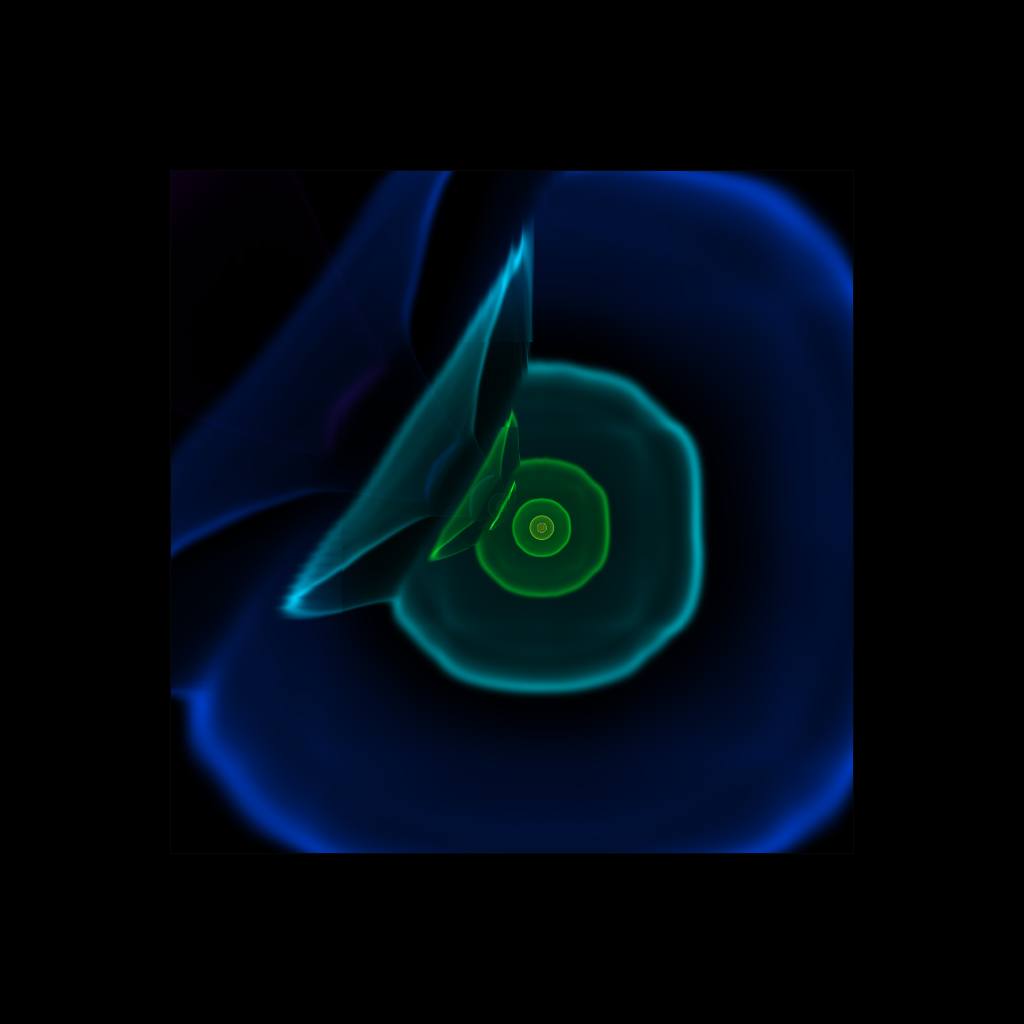

In [7]:
sc = yt.create_scene(ts[0], ('gas', 'density'))
cam = sc.camera
cam.resolution = (1024, 1024) # resolution of each frame
cam.switch_orientation(normal_vector=[1, 0, 0], north_vector=[0, 0, 1])

sc.annotate_domain(ds, color=[1, 1, 1, 0.005]) # draw the domain boundary [r,g,b,alpha] sc.annotate_grids(ds, alpha=0.005) # draw the grid boundaries
sc.save('/mnt/local/thomas/frame0000.png', sigma_clip=4)
nspin = 5

sc.show()

# for i in cam.iter_rotate(np.pi, nspin): # rotate by 180 degrees over nspin frames
#     sc.save('/mnt/local/thomas/frame%04d.png' % (i+1), sigma_clip=4)




In [4]:
import yt

ds = yt.frontends.stream.StreamDataset

yt.frontends.stream.data_structures.StreamDataset